<a href="https://colab.research.google.com/github/lilfetz22/Health_Scores_CAP2/blob/google-colab/scripts/Health_Scores_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
import seaborn as sns
import warnings
import io
import lightgbm as lgb
import xgboost as xgb
from random import seed, randint,sample
from sklearn.cluster import DBSCAN,KMeans,AgglomerativeClustering,AffinityPropagation
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from google.colab import files


In [5]:
uploaded = files.upload()

Saving city_data_scaled.csv to city_data_scaled (4).csv
Saving tract_data_scaled.csv to tract_data_scaled (4).csv


In [0]:
city_data_scaled = pd.read_csv(io.BytesIO(uploaded['city_data_scaled.csv']))
tract_data_scaled = pd.read_csv(io.BytesIO(uploaded['tract_data_scaled.csv']))
city_data_scaled = city_data_scaled.set_index('stpl_fips')
tract_data_scaled = tract_data_scaled.set_index('stcotr_fips')

## Clustering

### KMeans

100%|██████████| 9/9 [00:01<00:00,  7.28it/s]


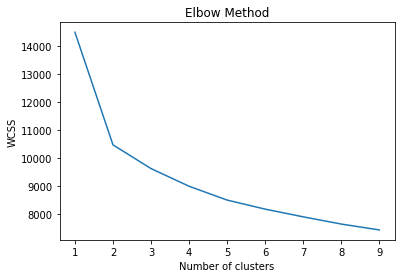

In [7]:
wcss = []
for i in tqdm(range(1, 10)):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(city_data_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

5 clusters

In [8]:
kmeans2 = KMeans(n_clusters=5, init='k-means++')
kmeans2.fit(city_data_scaled)
pred = kmeans2.predict(city_data_scaled)
frame=city_data_scaled.copy()
frame['cluster'] = pred
frame['cluster'].value_counts()

4    112
0    109
1     83
3     69
2     68
Name: cluster, dtype: int64

In [0]:
frame_small = frame.loc[:, ['cluster','Absenteeism','Air pollution - particulate matter','Binge drinking',
                            'Breast cancer deaths']]
cancer = frame.loc[:, ['cluster','Breast cancer deaths','Cardiovascular disease deaths',
                       'Colorectal cancer deaths','Diabetes']]

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


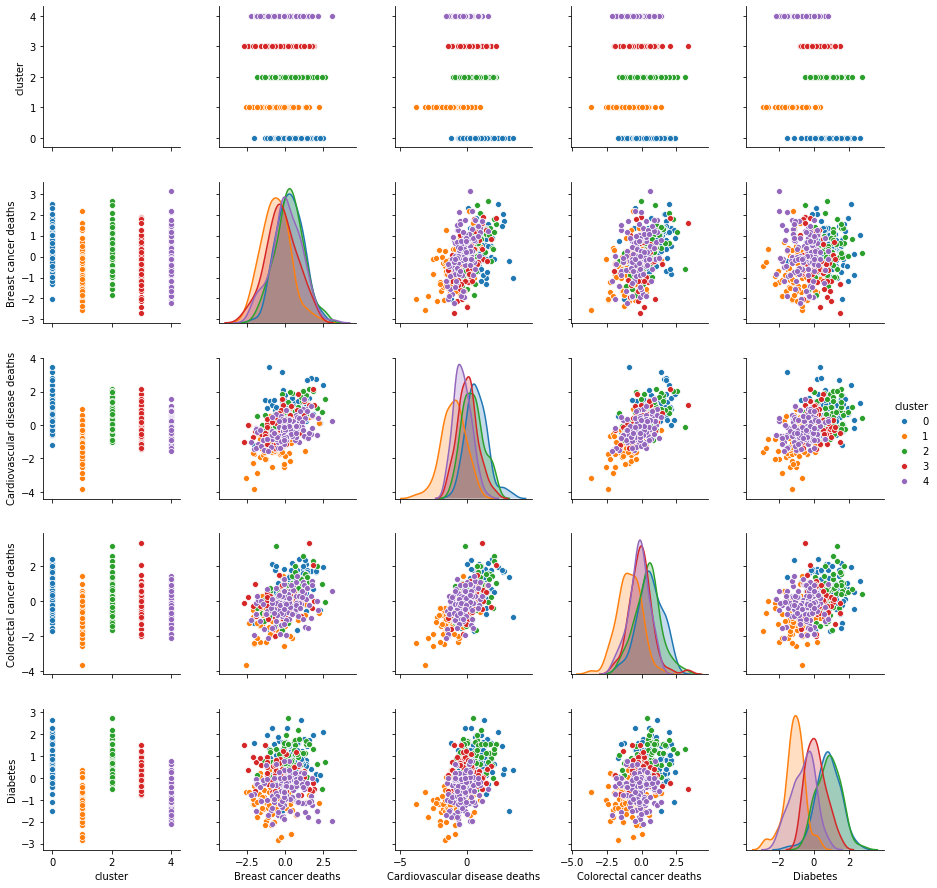

In [10]:
sns.pairplot(cancer, hue='cluster')

100%|██████████| 9/9 [00:13<00:00,  2.04s/it]


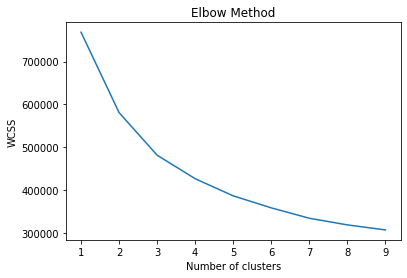

In [11]:
wcss2 = []
for i in tqdm(range(1, 10)):
    kmeans2 = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans2.fit(tract_data_scaled)
    wcss2.append(kmeans2.inertia_)
plt.plot(range(1,10), wcss2)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [12]:
kmeans3 = KMeans(n_clusters=5, init='k-means++')
kmeans3.fit(tract_data_scaled)
pred2 = kmeans3.predict(tract_data_scaled)
frame2=tract_data_scaled.copy()
frame2['cluster'] = pred2
frame2['cluster'].value_counts()

4    9286
1    5992
0    5102
3    3635
2    2833
Name: cluster, dtype: int64

### DBSCAN

In [0]:
city_arr = np.array(city_data_scaled)

In [0]:
dbsc = DBSCAN(eps=.5, min_samples=30)
labels = dbsc.fit_predict(city_arr)

### Hierarchical Clustering

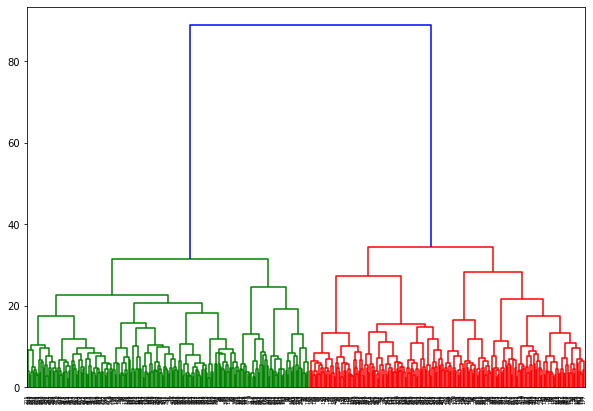

In [12]:
plt.figure(figsize=(10,7))
dend = shc.dendrogram(shc.linkage(city_data_scaled, method='ward'))

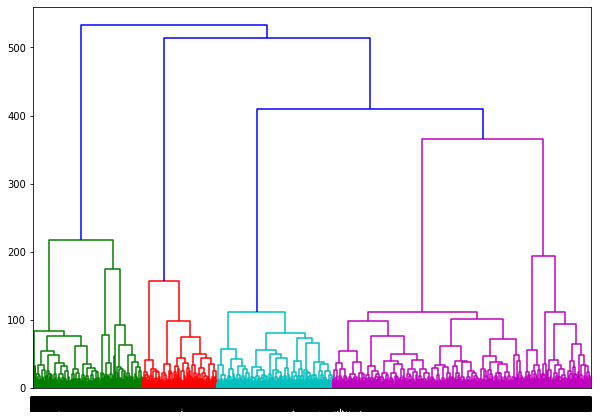

In [14]:
plt.figure(figsize=(10,7))
dend2 = shc.dendrogram(shc.linkage(tract_data_scaled, method='ward'))

In [0]:
cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean',linkage='ward')
agg_pred = cluster.fit_predict(city_data_scaled)
cds_copy = city_data_scaled.copy()
cds_copy['agg_predicted'] = agg_pred

In [0]:
cluster_t = AgglomerativeClustering(n_clusters=5, affinity='euclidean',linkage='ward')
agg_pred_t = cluster_t.fit_predict(tract_data_scaled)
tds_copy = tract_data_scaled.copy()
tds_copy['agg_predicted'] = agg_pred_t

In [0]:
sequence = list(range(0,42))

In [18]:
rand_cols = sample(sequence, 4)
rand_cols.append(42)
rand_cols

[38, 19, 25, 17, 42]

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


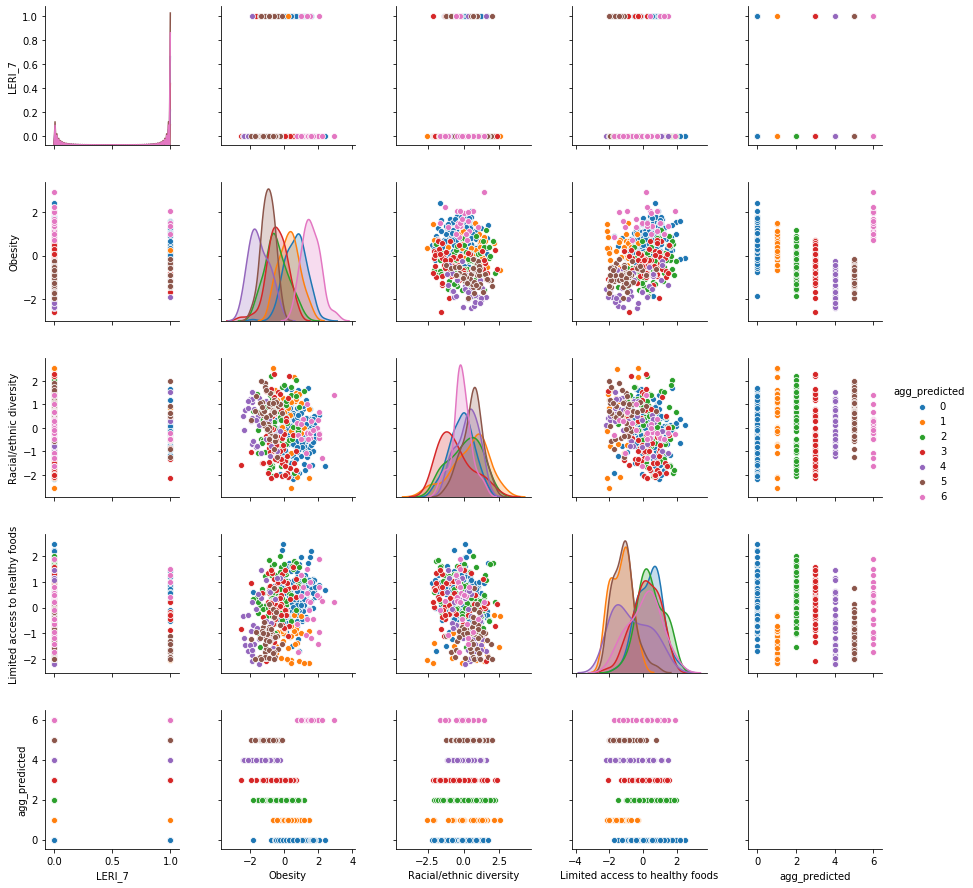

In [19]:
sns.pairplot(cds_copy.iloc[:, rand_cols], hue='agg_predicted')

### AffinityPropagation

In [0]:
affprop = AffinityPropagation()
affpred = affprop.fit_predict(city_data_scaled)
cds_aff = city_data_scaled.copy()
cds_aff['aff_pred']=affpred

In [0]:
# causes the session to crash on google colab and on my computer
# affprop = AffinityPropagation()
# tds_aff = tract_data_scaled.copy()
# affpred_t = affprop.fit_predict(tract_data_scaled)
# tds_aff['aff_pred']=affpred_t

In [0]:
zto3 = list(range(0,4))
fourto7 = list(range(4,8))
eightto11 = list(range(8,12))
twelveto15 = list(range(12,16))
sixteento19 = list(range(16,20))
twentyto23 = list(range(20,24))
zto3.append(42)

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


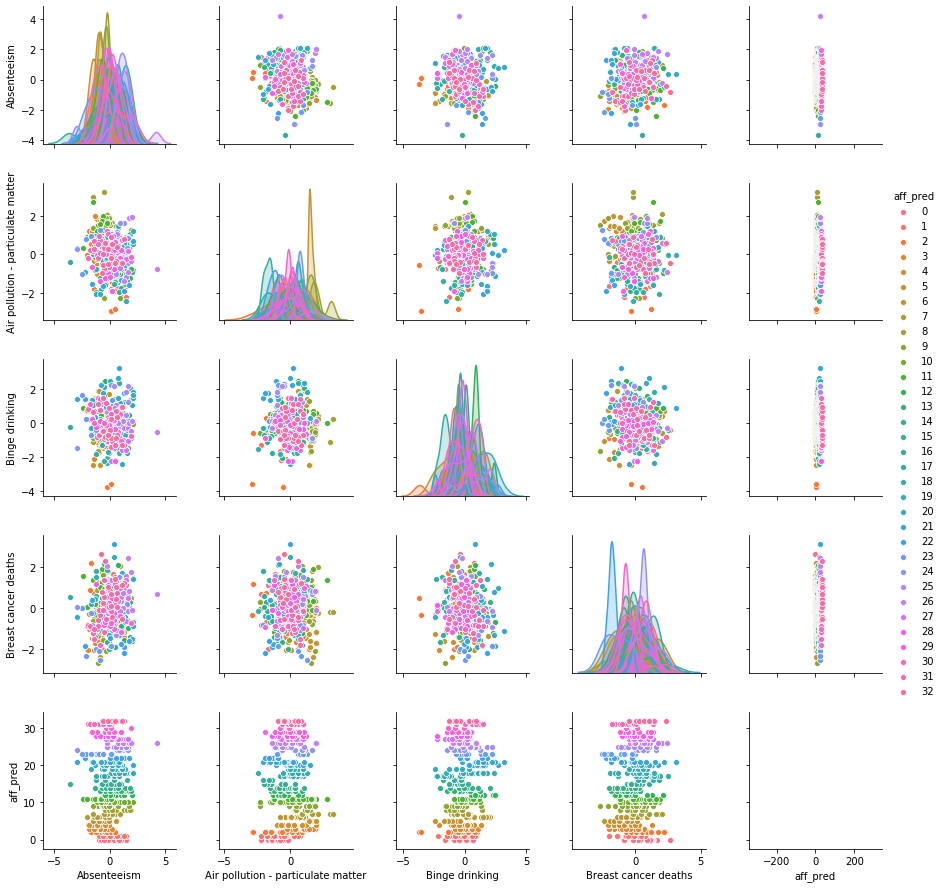

In [23]:
sns.pairplot(cds_aff.iloc[:, zto3],hue='aff_pred')

# Classification

#### Logistic Regression

In [0]:
# scoring classification models
def cv_score(clf, x, y, score_func=accuracy_score):
    result=0
    nfold=5
    for train, test in KFold(nfold).split(x):
        clf.fit(x[train],y[train])
        result += score_func(clf.predict(x[test]), y[test])
    return result/nfold #average

In [0]:
# using kmeans clustering
warnings.filterwarnings('ignore')
def logreg_fx(data, data_cluster):
  X_tr, X_test, y_tr,y_test = train_test_split(data.values, data_cluster.values,
                                                      random_state=5)
  c_space = np.logspace(0.001, 0.1, 1, 10, 100)
  logreg = LogisticRegression()
  param_grid = {'C': c_space}
  logreg_cv = GridSearchCV(logreg, param_grid, cv=5)
  logreg_cv.fit(X_tr, y_tr)

  print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
  print("Best score is {}".format(logreg_cv.best_score_))
  logreg_best = LogisticRegression(C=logreg_cv.best_params_['C'])
  score = cv_score(logreg_best, X_tr, y_tr)
  return score

In [27]:
city_score = logreg_fx(city_data_scaled, frame['cluster'])
print(city_score)
logreg_fx(tract_data_scaled, frame2['cluster'])

Tuned Logistic Regression Parameters: {'C': 1.0046157902783952}
Best score is 0.8
0.790909090909091
Tuned Logistic Regression Parameters: {'C': 1.0046157902783952}
Best score is 0.9295788637266588


0.9295789666030363

In [28]:
city_score2 = logreg_fx(city_data_scaled, cds_copy['agg_predicted'])
print(city_score2)
logreg_fx(tract_data_scaled, tds_copy['agg_predicted'])

Tuned Logistic Regression Parameters: {'C': 1.0046157902783952}
Best score is 0.7909090909090909
0.7878787878787878
Tuned Logistic Regression Parameters: {'C': 1.0046157902783952}
Best score is 0.942938021454112


0.9427395985735807

In [29]:
city_score3 = logreg_fx(city_data_scaled, cds_aff['aff_pred'])
city_score3
# cannot get Affinity clustering to work on computer for tract data

Tuned Logistic Regression Parameters: {'C': 1.0046157902783952}
Best score is 0.6484848484848484


0.5757575757575757

#### Random Forest

In [0]:
c_space = np.logspace(0.001, 0.1, 1, 10, 100)
log_param_grid = {'C': c_space}

In [0]:
def rf_fx(data, data_cluster):
  X_tr, X_test, y_tr,y_test = train_test_split(data.values, data_cluster.values,
                                                      random_state=5)
  features = list(data.columns)
  mod = RandomForestClassifier()
  mod_base_fit = mod.fit(X_tr, y_tr)
  mod_base_pred = mod_base_fit.predict(X_test)
  mod_base_score = accuracy_score(y_test, mod_base_pred)
  print("Baseline Score: {}".format(mod_base_score))

  feature_importance = list(zip(features, mod_base_fit.feature_importances_))
  fi_df = pd.DataFrame(feature_importance, columns=['Feature','importance'])
  fi_df = fi_df.sort_values('importance', ascending=False)
  return fi_df

In [47]:
rf_fx(city_data_scaled, frame['cluster'])

Baseline Score: 0.8918918918918919


,Feature,importance
5,Children in Poverty,0.087048
23,Premature deaths (all causes),0.073963
31,Walkability,0.066570
26,Smoking,0.065822
15,Income Inequality,0.059053
8,Diabetes,0.055310
17,Limited access to healthy foods,0.053128
7,Dental care,0.046651
10,Frequent physical distress,0.043052
21,Park access,0.038709


In [48]:
rf_fx(tract_data_scaled, frame2['cluster'])

Baseline Score: 0.9460667461263409


,Feature,importance
11,Limited access to healthy foods,0.323099
3,Dental care,0.142593
4,Diabetes,0.066269
13,Physical inactivity,0.055477
5,Frequent mental distress,0.054438
2,Children in Poverty,0.050986
14,Preventive services,0.041802
9,Income Inequality,0.039921
12,Obesity,0.032916
16,Smoking,0.032147


In [49]:
rf_fx(city_data_scaled, cds_copy['agg_predicted'])

Baseline Score: 0.7567567567567568


,Feature,importance
8,Diabetes,0.084397
5,Children in Poverty,0.084063
23,Premature deaths (all causes),0.062506
17,Limited access to healthy foods,0.060533
14,Housing with potential lead risk,0.048865
15,Income Inequality,0.048405
26,Smoking,0.048350
9,Frequent mental distress,0.043320
11,High blood pressure,0.040589
13,"Housing cost, excessive",0.040282


In [50]:
rf_fx(tract_data_scaled, tds_copy['agg_predicted'])

Baseline Score: 0.9451728247914184


,Feature,importance
11,Limited access to healthy foods,0.385215
2,Children in Poverty,0.153719
3,Dental care,0.071629
16,Smoking,0.053859
4,Diabetes,0.036679
9,Income Inequality,0.034021
12,Obesity,0.031996
5,Frequent mental distress,0.026441
14,Preventive services,0.025081
8,Housing with potential lead risk,0.022593


In [51]:
rf_fx(city_data_scaled, cds_aff['aff_pred'])

Baseline Score: 0.3963963963963964


,Feature,importance
31,Walkability,0.058100
13,"Housing cost, excessive",0.053521
14,Housing with potential lead risk,0.046699
1,Air pollution - particulate matter,0.038297
26,Smoking,0.037198
12,High school graduation,0.037039
23,Premature deaths (all causes),0.034201
21,Park access,0.033379
27,Third-grade reading proficiency,0.032901
2,Binge drinking,0.032393


#### Light GBM

In [0]:
def gbm_fx(data, data_cluster):
  X_tr, X_test, y_tr,y_test = train_test_split(data.values, data_cluster.values,
                                                      random_state=5)
  features = list(data.columns)
  evaluation_dict = {}
  gbm = lgb.LGBMRanker()
  q_train = [X_tr.shape[0]]
  mod_base_fit = gbm.fit(X_tr, y_tr, group=q_train, callbacks=[lgb.record_evaluation(evaluation_dict)])
  mod_base_pred = mod_base_fit.predict(X_test)
  

  feature_importance = list(zip(features, mod_base_fit.feature_importances_))
  fi_df = pd.DataFrame(feature_importance, columns=['Feature','importance'])
  fi_df = fi_df.sort_values('importance', ascending=False)
  return fi_df

In [184]:
gbm_fx(city_data_scaled, frame['cluster'])

,Feature,importance
16,Life expectancy,88
5,Children in Poverty,71
13,"Housing cost, excessive",66
23,Premature deaths (all causes),65
21,Park access,58
22,Physical inactivity,57
10,Frequent physical distress,56
15,Income Inequality,54
31,Walkability,49
7,Dental care,47


In [63]:
gbm_fx(tract_data_scaled, frame2['cluster'])

Best Score: defaultdict(<class 'dict'>, {})


,Feature,importance
0,Air pollution - particulate matter,0
15,Racial/ethnic diversity,0
27,LERI_9,0
26,LERI_8,0
25,LERI_7,0
24,LERI_6,0
23,LERI_5,0
22,LERI_4,0
21,LERI_3,0
20,LERI_2,0


In [64]:
gbm_fx(city_data_scaled, cds_copy['agg_predicted'])

Best Score: defaultdict(<class 'dict'>, {})


,Feature,importance
8,Diabetes,93
22,Physical inactivity,88
5,Children in Poverty,76
17,Limited access to healthy foods,74
14,Housing with potential lead risk,68
19,Obesity,61
21,Park access,61
4,Cardiovascular disease deaths,55
26,Smoking,51
29,Uninsured,43


In [169]:
gbm_fx(tract_data_scaled, tds_copy['agg_predicted'])

defaultdict(<class 'dict'>, {})


,Feature,importance
11,Limited access to healthy foods,429
2,Children in Poverty,308
0,Air pollution - particulate matter,196
10,Life expectancy,171
17,Unemployment,167
13,Physical inactivity,161
9,Income Inequality,152
3,Dental care,148
16,Smoking,148
12,Obesity,132


In [0]:
# gbm_fx(city_data_scaled, cds_aff['aff_pred'])

In [0]:
def gbm_Class_fx(data, data_cluster):
  X_tr, X_test, y_tr,y_test = train_test_split(data.values, data_cluster.values,
                                                      random_state=5)
  features = list(data.columns)
  gbm = lgb.LGBMClassifier()
  q_train = [X_tr.shape[0]]
  mod_base_fit = gbm.fit(X_tr, y_tr)
  mod_base_pred = mod_base_fit.predict(X_test)
  score = accuracy_score(y_test, mod_base_pred)
  print("Score: {}".format(score))
  print("Classes: {}".format(mod_base_fit.classes_))
  kfold = StratifiedKFold(n_splits=5, random_state=7)
  results = cross_val_score(gbm, data.values, data_cluster.values, cv=kfold)
  print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

  feature_importance = list(zip(features, mod_base_fit.feature_importances_))
  fi_df = pd.DataFrame(feature_importance, columns=['Feature','importance'])
  fi_df = fi_df.sort_values('importance', ascending=False)
  return fi_df

In [156]:
gbm_Class_fx(city_data_scaled, frame['cluster'])

Score: 0.8828828828828829
Classes: [0 1 2 3 4]
Accuracy: 85.07% (4.70%)


,Feature,importance
5,Children in Poverty,325
10,Frequent physical distress,316
16,Life expectancy,309
17,Limited access to healthy foods,284
23,Premature deaths (all causes),254
26,Smoking,243
22,Physical inactivity,235
13,"Housing cost, excessive",232
20,Opioid overdose deaths,231
21,Park access,226


In [157]:
gbm_Class_fx(tract_data_scaled, frame2['cluster'])

Score: 0.9678188319427891
Classes: [0 1 2 3 4]
Accuracy: 96.66% (0.47%)


,Feature,importance
2,Children in Poverty,1615
13,Physical inactivity,1000
14,Preventive services,981
10,Life expectancy,943
11,Limited access to healthy foods,941
17,Unemployment,926
4,Diabetes,897
18,Uninsured,843
9,Income Inequality,829
5,Frequent mental distress,823


In [158]:
gbm_Class_fx(city_data_scaled, cds_copy['agg_predicted'])

Score: 0.8648648648648649
Classes: [0 1 2 3 4 5 6]
Accuracy: 81.60% (5.57%)


,Feature,importance
15,Income Inequality,514
14,Housing with potential lead risk,485
17,Limited access to healthy foods,398
8,Diabetes,398
10,Frequent physical distress,351
19,Obesity,351
26,Smoking,342
13,"Housing cost, excessive",333
22,Physical inactivity,332
5,Children in Poverty,321


In [159]:
gbm_Class_fx(tract_data_scaled, tds_copy['agg_predicted'])

Score: 0.9612634088200238
Classes: [0 1 2 3 4]
Accuracy: 94.82% (0.58%)


,Feature,importance
17,Unemployment,1331
11,Limited access to healthy foods,1298
3,Dental care,1112
13,Physical inactivity,1051
5,Frequent mental distress,1035
9,Income Inequality,1009
2,Children in Poverty,1005
18,Uninsured,788
10,Life expectancy,767
16,Smoking,713


In [160]:
gbm_Class_fx(city_data_scaled, cds_aff['aff_pred'])

Score: 0.5225225225225225
Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
Accuracy: 56.49% (3.70%)


,Feature,importance
27,Third-grade reading proficiency,1862
29,Uninsured,1687
17,Limited access to healthy foods,1607
1,Air pollution - particulate matter,1566
5,Children in Poverty,1556
25,Racial/ethnic diversity,1499
12,High school graduation,1490
21,Park access,1488
14,Housing with potential lead risk,1485
13,"Housing cost, excessive",1376


#### XGBoost

In [0]:
def xgm_fx(data, data_cluster):
  data_dmatrix = xgb.DMatrix(data=data,label=data_cluster)
  X_tr, X_test, y_tr,y_test = train_test_split(data.values, data_cluster.values,
                                                      random_state=5)
  features = list(data.columns)
  xgm = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
  
  mod_base_fit = xgm.fit(X_tr, y_tr)
  mod_base_pred = mod_base_fit.predict(X_test)
  score = accuracy_score(y_test, mod_base_pred)
  print("Score: {}".format(score))
  print("Classes: {}".format(mod_base_fit.classes_))

  params = {'binary':'logistic','colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

  cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="error", as_pandas=True, seed=42)
  print(cv_results)

  xgb.plot_importance(mod_base_fit)
  plt.rcParams['figure.figsize'] = [5, 5]
  plt.show()

  kfold = StratifiedKFold(n_splits=5, random_state=7)
  results = cross_val_score(xgm, data.values, data_cluster.values, cv=kfold)
  print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

  feature_importance = list(zip(features, mod_base_fit.feature_importances_))
  fi_df = pd.DataFrame(feature_importance, columns=['Feature','importance'])
  fi_df = fi_df.sort_values('importance', ascending=False)
  return fi_df

Score: 0.8648648648648649
Classes: [0 1 2 3 4]
   train-error-mean  train-error-std  test-error-mean  test-error-std
0         -1.068027         0.074727        -0.843538        0.191042
1         -1.150793         0.076679        -1.036281        0.178462
2         -1.142857         0.066363        -1.083900        0.144876


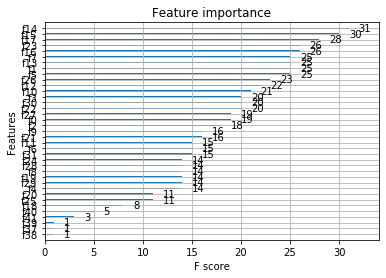

Accuracy: 84.14% (6.27%)


,Feature,importance
16,Life expectancy,0.073448
10,Frequent physical distress,0.067506
41,LERI_10,0.065635
5,Children in Poverty,0.063422
8,Diabetes,0.052670
22,Physical inactivity,0.051816
21,Park access,0.045353
15,Income Inequality,0.041270
23,Premature deaths (all causes),0.040805
31,Walkability,0.036125


In [164]:
xgm_fx(city_data_scaled, frame['cluster'])

Score: 0.8265792610250298
Classes: [0 1 2 3 4]
    train-error-mean  train-error-std  test-error-mean  test-error-std
0          -1.258232         0.010521        -1.243966        0.009976
1          -1.261211         0.009343        -1.254432        0.010826
2          -1.265122         0.005830        -1.259162        0.018576
3          -1.265178         0.009872        -1.260578        0.014245
4          -1.276240         0.005195        -1.274322        0.025815
5          -1.291139         0.004791        -1.288401        0.016843
6          -1.291884         0.004629        -1.287806        0.016910
7          -1.294231         0.007495        -1.292461        0.015223
8          -1.297732         0.005932        -1.295776        0.015456
9          -1.300451         0.005953        -1.297750        0.015308
10         -1.301456         0.006405        -1.298644        0.015245
11         -1.297695         0.007985        -1.295106        0.012952
12         -1.298886         0

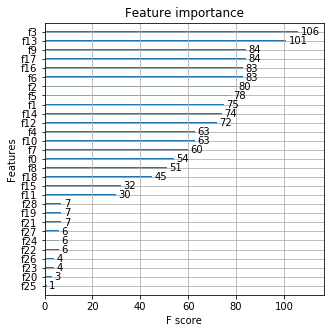

Accuracy: 81.71% (2.30%)


,Feature,importance
11,Limited access to healthy foods,0.425240
3,Dental care,0.088346
5,Frequent mental distress,0.076290
13,Physical inactivity,0.073476
12,Obesity,0.042103
9,Income Inequality,0.030120
4,Diabetes,0.029540
2,Children in Poverty,0.026854
16,Smoking,0.025008
8,Housing with potential lead risk,0.023085


In [165]:
xgm_fx(tract_data_scaled, frame2['cluster'])

Score: 0.8108108108108109
Classes: [0 1 2 3 4 5 6]
    train-error-mean  train-error-std  test-error-mean  test-error-std
0          -1.180272         0.024684        -0.784580        0.239183
1          -1.252835         0.023620        -0.995465        0.108607
2          -1.244898         0.042027        -1.058957        0.051609
3          -1.162132         0.050932        -0.979592        0.047457
4          -1.181406         0.018491        -1.002268        0.023125
5          -1.210884         0.019440        -1.018141        0.023125
6          -1.218821         0.024264        -1.009070        0.012827
7          -1.231292         0.005554        -1.034014        0.060080
8          -1.226757         0.004242        -1.029478        0.047889
9          -1.229025         0.003206        -1.058957        0.069891
10         -1.235828         0.008484        -1.072562        0.057006
11         -1.239229         0.011224        -1.070294        0.050399
12         -1.244898      

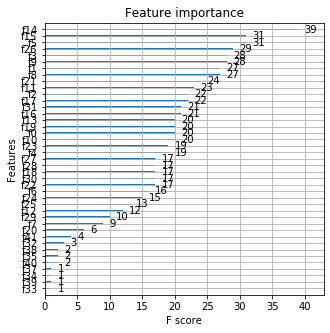

Accuracy: 79.99% (5.45%)


,Feature,importance
32,LERI_1,0.118147
22,Physical inactivity,0.068445
10,Frequent physical distress,0.056145
9,Frequent mental distress,0.044369
17,Limited access to healthy foods,0.041644
14,Housing with potential lead risk,0.040571
8,Diabetes,0.039435
26,Smoking,0.038723
15,Income Inequality,0.036302
5,Children in Poverty,0.035382


In [166]:
xgm_fx(city_data_scaled, cds_copy['agg_predicted'])

Score: 0.8139153754469607
Classes: [0 1 2 3 4]
    train-error-mean  train-error-std  test-error-mean  test-error-std
0          -0.689455         0.002460        -0.676624        0.005277
1          -0.713331         0.006915        -0.705267        0.007146
2          -0.719104         0.005474        -0.711897        0.007141
3          -0.718098         0.005809        -0.711562        0.007581
4          -0.753873         0.040897        -0.746985        0.049364
5          -0.813860         0.001660        -0.809521        0.009687
6          -0.809073         0.001149        -0.805088        0.009410
7          -0.832799         0.017878        -0.828071        0.028283
8          -0.840156         0.005728        -0.836636        0.008867
9          -0.847084         0.014819        -0.840733        0.006419
10         -0.843564         0.016485        -0.838684        0.008231
11         -0.843508         0.015656        -0.837827        0.009353
12         -0.846898         0

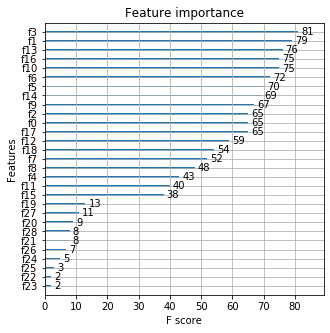

Accuracy: 80.80% (2.51%)


,Feature,importance
11,Limited access to healthy foods,0.422244
2,Children in Poverty,0.083971
5,Frequent mental distress,0.083314
9,Income Inequality,0.059391
3,Dental care,0.057870
14,Preventive services,0.041822
16,Smoking,0.022758
7,"Housing cost, excessive",0.021348
13,Physical inactivity,0.020782
12,Obesity,0.019984


In [167]:
xgm_fx(tract_data_scaled, tds_copy['agg_predicted'])

Score: 0.40540540540540543
Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
   train-error-mean  train-error-std  test-error-mean  test-error-std
0        -14.232426         0.434606       -12.961451        0.376567
1        -14.304989         0.475780       -14.306123        0.951523
2        -14.308390         0.473921       -14.312925        0.955599


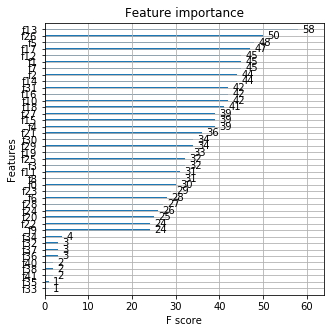

Accuracy: 51.48% (4.99%)


,Feature,importance
32,LERI_1,0.083381
41,LERI_10,0.064414
34,LERI_3,0.038935
33,LERI_2,0.037999
13,"Housing cost, excessive",0.031022
19,Obesity,0.031005
16,Life expectancy,0.030436
20,Opioid overdose deaths,0.029788
7,Dental care,0.029694
26,Smoking,0.028442


In [168]:
xgm_fx(city_data_scaled, cds_aff['aff_pred'])

#### Ranking 

In [0]:
cc = list(city_data_scaled.columns)
tc = list(tract_data_scaled.columns)

In [0]:
ascending_false = ['Dental care','High school graduation','Income Inequality','Life expectancy','Park access','Preventive services',
                   'Racial/ethnic diversity','Third-grade reading proficiency','Walkability'] # good to be positive
ascending_true = ['Absenteeism','Air pollution - particulate matter','Binge drinking','Breast cancer deaths',
                  'Cardiovascular disease deaths', 'Children in Poverty','Colorectal cancer deaths','Diabetes',
                  'Frequent mental distress','Frequent physical distress', 'High blood pressure', 'Housing cost, excessive',
                  'Housing with potential lead risk','Limited access to healthy foods','Neighborhood racial/ethnic segregation',
                  'Obesity','Opioid overdose deaths','Physical inactivity','Premature deaths (all causes)','Smoking','Unemployment',
                  'Uninsured','Violent crime','Lead exposure risk index']# good to be negative

In [0]:
a_false_tract = []
a_true_tract = []
for feat in tc:
  if feat in ascending_false:
    a_false_tract.append(feat)
  if feat in ascending_true:
    a_true_tract.append(feat)

In [0]:
def sorting_ranking_fx(df,a_false, a_true):
  new_df = df.copy()
  for col in df.columns:
    if col in a_false:
      new_df = new_df.sort_values(col, ascending=False)
    if col in a_true:
      new_df = new_df.sort_values(col)
    new_df[col+'_rank'] = range(1, len(df[col])+1)
  names = list(new_df.columns)
  ranks = []
  for n in names:
    ranks.append(n.endswith('_rank'))
  just_ranks = new_df.loc[:, ranks]
  return just_ranks

In [0]:
# no LERI
city_no_leri = city_data_scaled.iloc[:, :-10]
tract_no_leri = tract_data_scaled.iloc[:, :-10]

In [0]:
city_ranked = sorting_ranking_fx(city_no_leri, ascending_false, ascending_true)
tract_ranked = sorting_ranking_fx(tract_no_leri, a_false_tract, a_true_tract)

##### Adding Weights

In [0]:
import re
def feature_weights(df, weights):
  weighted_df = df.copy()
  for col in df.columns:
    weighted_df[col+'_w'] = df[col]*weights[re.sub('\_rank$', '', col)]
  names = list(weighted_df.columns)
  ws = []
  for n in names:
    ws.append(n.endswith('_w'))
  just_weights = weighted_df.loc[:, ws]
  just_weights['Overall Health Score'] = just_weights.sum(axis=1)
  return(just_weights)